# RISC-V 3D Chip Design with TSV and Thermal Modeling

RIOS Lab, TsingHua University, 2024

SPDX-License-Identifier: Apache-2.0

</br>

#### Team Members

|Name|Affiliation|
|:--:|:----------:|
| Yifei Zhu (zhuyf20@mails.tsinghua.edu.cn)| RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|
| Weiwei Chen (weiwei.c@rioslab.org)| RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|
| Lei Ren (ren@rioslab.org)| RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|
| Zhangxi Tan (xtan@rioslab.org)| RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|
<!-- | Xieyuan Wu (wuxy23@mails.tsinghua.edu.cn)| RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|
| Yucheng Wang (wangyc23@mails.tsinghua.edu.cn)| RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University| -->


## Abstract
Amid the escalating need for high-performance, low-power, and densely integrated electronic systems, 3D-ICs emerge as a promising "more than Moore'' integration solution. Nevertheless, the scarcity of specialized EDA tools and standardized design flows tailored for 3D chiplets hinders silicon innovation. To address this gap, we propose a 3D RISC-V processor, mimicking AMD's 3D V-cache architecture. To realize this architecture, we develop 'Open3DFlow', an open-source 3D IC design platform that leverages existing openEDA tools while incorporating tailored abstractions and customizations optimized for 3D chiplet designs. Besides OpenROAD, we also integrate other open tools to enable Through Silicon Via (TSV) modeling, thermal analysis, and signal integrity (SI) assessments. Our CPU consists of two tiers: a cache die and a logic die, stacked face-to-face (F2F) using different processes. The interconnects converge at the central bonding layer, where the bonding pads are located. Our ambition is to establish a fully open-source realization of cutting-edge technologies, not only to facilitate the resolution of future challenges within this platform but also to pave the way for the exploration of novel packaging paradigms.

## 1.   Introduction and Spec
In the realm of microelectronics, the pursuit of superior performance, energy efficiency, optimized space utilization, and economical solutions has spurred the development of novel integration techniques. Given the need for semiconductor memory chips with higher density to support recently released CPU components, the technique for advanced packages has emerged as a promising solution.

The technological trend can be roughly divided into four stages:    
- 2D package, with solder balls or bumps as the representative connection method. (Flip chip, wire bonding)
- Wafer Level Packaging, utilizing Redistribution Layer (RDL) as the representative connection approach. (INFO-PoP, eWLB)
- 2.5D package, typically based on interposer or Embedded Multi-die Interconnect Bridge. (EMIB, CoWoS-x)
- 3D stacking, employing hybrid bonding and Through Silicon Vias (TSVs) for signal and power transmission. (3D SoIC)

As depicted in the following diagram, the trend consistently leans towards achieving greater integration and shorter interconnection distances:

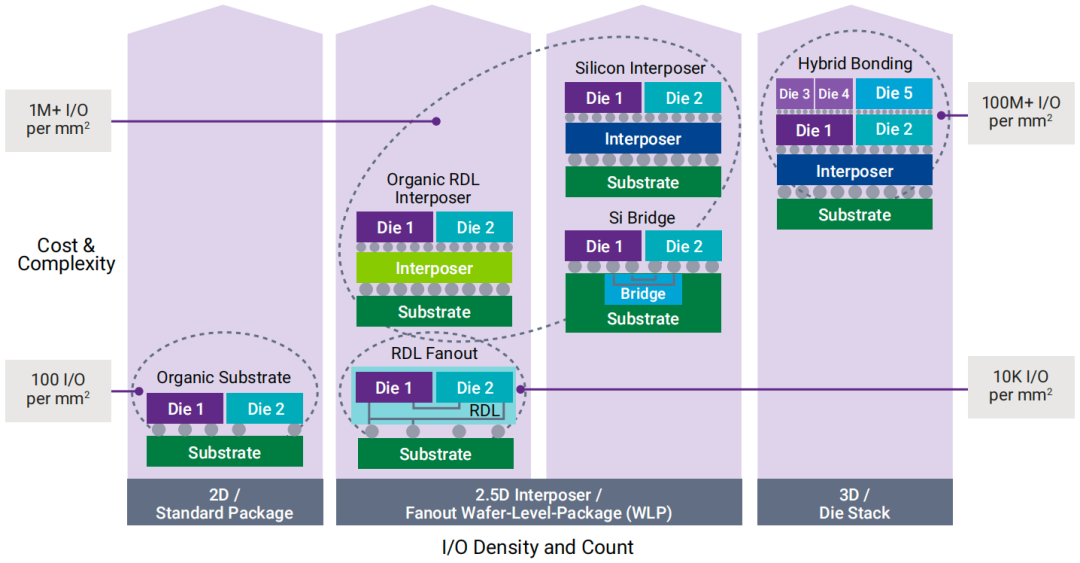

Currently, the 3D IC flow faces several limitations. Primarily, it relies heavily on 2D tools and lacks comprehensive thermal analysis as well as power and signal integrity (SI) assessments. And because there are knowledge gaps between chip design and packaging. Modeling for 3D items such as TSVs and bonding pads hardly exists in IC back-end processes. Additionally, due to the immature and closed nature of existing 3D design EDA tools, future designs face challenges in integrating with large models and cloud platforms. Commercial licensing costs and limitations on processor scalability in cloud environments further complicate the matter.

To address these issues, in the work, we present our own 3D IC design methodology. We develop a 5-stage-pipeline RISC-V CPU with its cache die stacking on the logic die, which mimics AMD's 3D V-cache architecture. We incorporate openPDKs and openEDA tools while doing the hardening. For that end, we propose an open source 3D chip EDA design platform with TSV and thermal modeling named 'Open3DFlow'. It is also the first fully open-source process for designing 3D chips, which is poised to significantly contribute to the vibrant growth of the open-source community. Our goal is to tape out this design through the OpenMPW program, and the process will be easily extended to include logic+DRAM or logic+logic configurations. 

The significance of this work can be summarized:
1.  We build a 3D RISC-V chip in fully open-source mode, leveraging open EDA tools, incorporating hybrid bonding and TSV technologies.
2.  we propose 'Open3DFlow', an open source EDA platform that offers comprehensive TSV/Chip's SI and thermal analysis, ensuring reliable and efficient 3D IC designs
3.  The open-source nature facilitates seamless integration with AI, large models, and cloud computing, boosting design efficiency for complex 3D ICs.

    Architecure Specification：
We employ a five-stage pipelined RISC-V CPU equipped with an L1 cache to demonstrate our 3D IC design flow. In the future, we will transition towards more intricate designs to co-optimize our toolchains. The core was created for an OSU undergraduate course in July 2019, we have modified it to fit for our 3D design flow. Here we summarize the key features:
- 32-bit CPU RISC-V supporting I extension 
- 5-stage pipeline in-order execution
- 1KB L1 cache concatenate by 4 sram macros
- PDK for logic die：SkyWater 130nm (Sky130A)
- PDK for cache die: GlobalFoundries 180nm (GF180)
- Connection methods: bonding pads for hybrid bonding & TSV


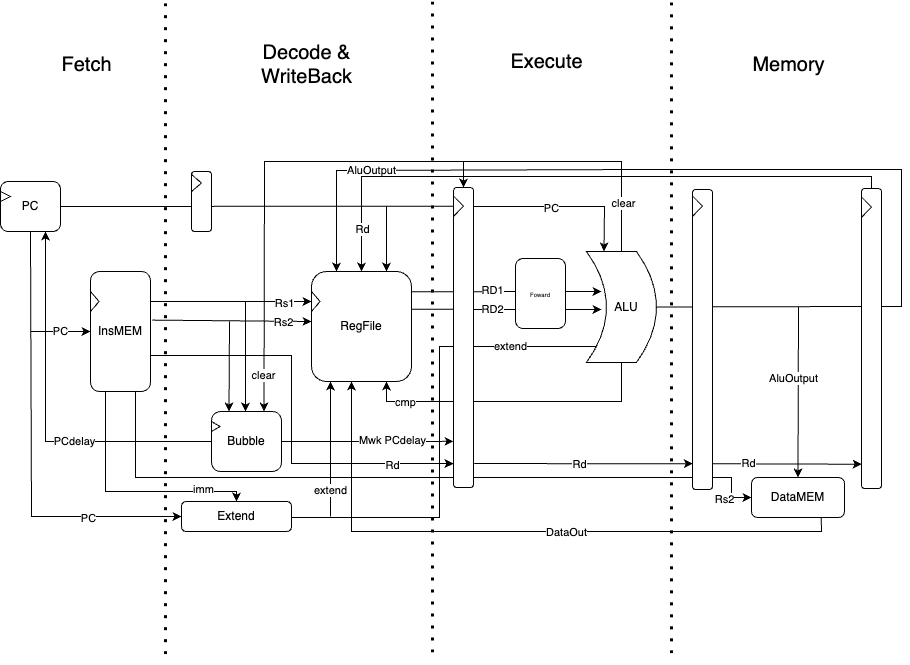

Next, we will demonstrate the operations step by step with this article. For quick start of our flow, you can turn to section [Quick Start](#Simulation_Flow)

## 2.   Architecture Design of 3D RISC-V Processor with V-Cache
### 2.1 Chiplet Consideration
There are some typical structures for 3D processors. As depicted in the following figure:

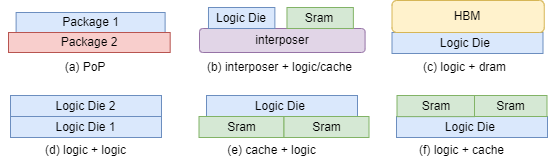

(a) depicts combinations of multiple packages; (b) represents 2.5D IC, applying passive or active interposers; (c) illustrates for DRAMs on logic dies; (d) stacks one logic circuit on another; and in (d), SRAMs are positioned beneath the logic but for (f), the logic is on the upper side. 

However, modern 3D processor architectures often combine multiple stacking approaches. The prevailing trend in 3D architecture evolution is towards increased density integration, reduced micro-bumps and TSV pitches, as well as shorter chiplet distances. For instance, AMD's 3D-Vcache does not follow the traditional approach of placing caches alongside the processor; instead, it stacks additional cache layers on top of the CPU. This architecture enables AMD to compress more cache without fabricating larger CPUs, resulting in improved speed and power efficiency in gaming applications. To achieve broader bandwidth and faster transmission speeds, the hybrid bonding technology even eliminates bumps. In our design, we select the "CPU + Caches" structure for experimentation. We aim to develop a fully open-source 3D-Vcache structure utilizing openEDA tools and openPDKs. Our aspiration is also to establish a platform that can be flexibly extended to other stacking modes in the future.

### 2.2 V-Cache Structure
The L1 cache is composed by concatenating 4 GF180 256*8-SRAM  macros, utilizing a 7-bit address for both reading and writing operations. As shown in this figure:

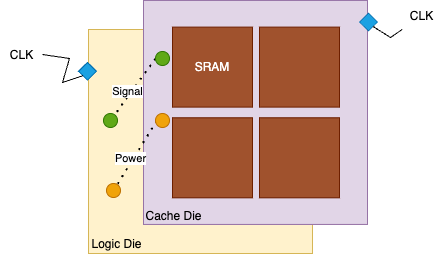

All signals related to this cache die, excluding the clock signal, establish direct communication with the logic die via bonding pads and TSVs. The floorplan for the macros is manually crafted. The two ties possess their own independent power supply networks, but converge on the logic die. Detailed insights into the back-end design are outlined in the subsequent sections.

### 2.3  RISC-V CPU with 3D Stacking SRAM
The overall stacked architecture is illustrated as:

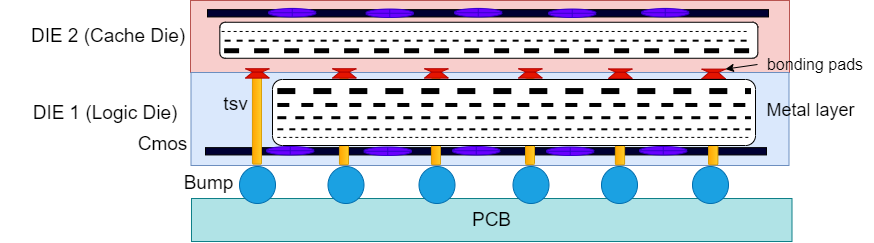

In our study, two dies are stacked in a F2F configuration, which means that their corresponding connection signal points converge onto the same bonding pads on the bonding layer. Additionally, the TSVs are via-last fabricated, where they reach the topmost layer of the top die and penetrate through all the metal layers of the sub die. Finally, the entire 3D chip is mounted on the substrate using flip-chip packaging with solder bumps.

## 3. Front-end Design
First you should clone our platform. The source codes are in 'designs/src'. The top module is 'riscv_top'.

In [47]:
!git clone https://github.com/b224hisl/Open3DFlow.git
!cd Open3DFlow
!git pull
!cd ..

Cloning into 'Open3DFlow'...


remote: Enumerating objects: 824, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 824 (delta 7), reused 27 (delta 5), pack-reused 790
Receiving objects: 100% (824/824), 113.77 MiB | 2.58 MiB/s, done.
Resolving deltas: 100% (197/197), done.
Updating files: 100% (787/787), done.
Already up to date.


### 3.1 Logic Processor Die RTL
This processor was originally created for an OSU undergraduate course in July 2019. We have edited it for 3D IC design flow. The hierarchy of the logic processor RTL code can be shown as:

- core_without_dmem （# the top module）
    - ROM (# boot )
    - dmem_communicate (# the module to communicate with SRAMs)
    - riscv (# logic)
        - contoller
            - aludec
            - maindec
        - datapath
            - alu
            - adder
            - comparator
            - regfile
            - shifter
            - signext

### 3.2 V-Cache Die Design
In the original processor design, there was no L1 cache, and the original author used an RTL model named 'fakeram' as a substitute. Our design incorporates four GF180 SRAM macros, specifically 'gf180mcu_fd_ip_sram__sram256x8m8wm1', to form a 1KB cache, with the module named ‘dmem’. During read operations, the four SRAMs simultaneously receive the address from the ‘core_without_dmem’ and collectively output 32-bit data. For write operations, the enabling signals control the writing to one or more SRAMs.

It is noteworthy that apart from the clock signal, ‘dmem’ does not have any signals originating from or exiting the entire CPU. Consequently, the total transmission signals between the V-cache die and the logic processor die can be summarized as follows:
- writedata[7:0]
- ce_mem[3:0]
- we_mem[3:0]
- dataadr[7:0]
- inter_dmem0[7:0]
- inter_dmem1[7:0]
- inter_dmem2[7:0]
- inter_dmem3[7:0]

## 4.   3D Back-end Design with Open3DFlow
### 4.1 Noval 3D Back-end Design Flow
To achieve this design, we developed a platform called 'Open3DFlow'. 'Open3DFlow' integrates a range of open-source tools and provides apt abstractions, augmented with specialized modules designed to simulate the 3D structure of hybrid bonding. Notably, the 2D backend of the chip leverages certain components from the existing workflow in OpenRoad.

The overall workflow of 'Open3DFlow' is depicted in this figure:

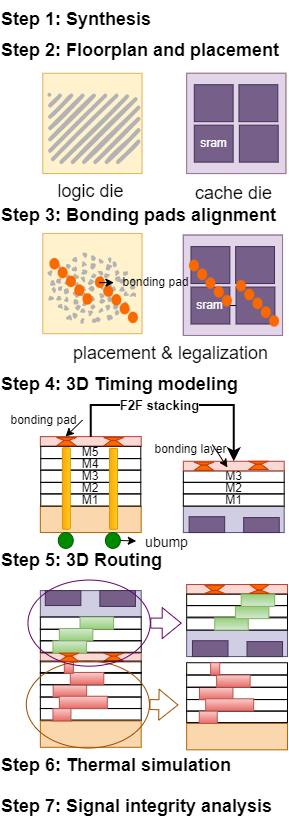

In the initial phase, we synthesize the RTL codes of the processor and V-cache to generate netlists respectively. They are synthesized using distinct PDKs.

Subsequently, we proceed to do floorplanning of both dies. The footprints of the two dies must be aligned with each other.

The next step involves the placement of standard cells and bonding pads. A key aspect of hybrid bonding is its transition from solder-based bump technology to direct copper-to-copper connections. So we introduce a dedicated 'bonding layer' for bonding pads. However, modifying the technology file of the full metal stack can introduce complexities in Design Rule Check (DRC) rules and RC extraction schedules. To maintain a reasonable F2F stacking structure, actually, the top layer of the V-cache die serves as the bonding layer. Consequently, this metal layer is not allowed for routing. Simultaneously, this bonding layer is integrated into the metal stack of the logic die. We have extracted the RLC characteristics and related dimensions of two die's all metal layers to construct the 3D chips' full backend-of-the-line (BEOL). Compared to other monolithic-3D methods, this approach simplifies modifications to the logic die's tlef, as we do not require actual routing on the bonding layer, just sacrificing the routing resources of the cache die.

Besides, the placement and legalization of stand cells are also involved at this stage, ensuring that the bonding pads of both dies align automatically.

Then, we model the delays and impedances introduced by 3D items such as bumps, TSVs, and bonding pads. The TSVs connect the upper bonding pads to the bumps, which interface with the RDL or package substrate. Delays can be abstracted and concentrated at their IOs. Detailed modeling will be discussed in the next section.

Next, the logic die and V-cache die are routed separately to obtain the final GDSII files. Although routing is performed individually for each die, the alignment of bonding pads, the parasitic parameters and time delays for 3D structure, obtained in the previous step, validate this flow for the final F2F-stacked 3D chip architecture. Even though it is relatively straightforward to change the two back-end processes to run in parallel, the main consideration is that the positions of the bonding pads should be routable for both dies. However, at present, we manually select their positions.

In the last two steps, we perform thermal simulation and SI analysis based on chip dimensions, power consumption, and other relevant parameters. Thermal simulations allow us to accurately assess the heat distribution within the chip, enabling us to optimize the cooling system in the future. The SI analysis helps identify potential electromagnetic interference issues.

### 4.2 Logic Processor Die Back-end Design
Here we write the configuration file for the core die. Note that our 'Open3DFlow', supports some new parameters such as 'BONDING_LAYER', 'MOTHER_PIN_GEN', etc. We will discuss the use of the entire tool chain on the platform in detail in the following chapters.

In [48]:
%%writefile core_die.mk
export DESIGN_NICKNAME = riscv32i_3d
export DESIGN_NAME = core_without_dmem
# top = dmem + core_without_dmem
export PLATFORM    = 130_180 #sky130 & GF180
export PLACE_DENSITY          = 0.5

export SYNTH_HIERARCHICAL = 1
export RTLMP_FLOW = True
export MAX_UNGROUP_SIZE ?= 1000

export VERILOG_FILES = $(sort $(wildcard ./designs/src/riscv32i_3d/*.v))
export SDC_FILE      = ./designs/130_180/$(DESIGN_NICKNAME)/constraint.sdc

export DIE_AREA = 0 0 1200 1000
export CORE_AREA = 20 20 1180 980

export PLACE_DENSITY_LB_ADDON = 0.12
export MACRO_PLACE_CHANNEL = 6 6
export TNS_END_PERCENT   = 100
export MIN_ROUTING_LAYER = met1
export BONDING_LAYER = Metal4
export MAX_ROUTING_LAYER = $(BONDING_LAYER)

export IO_CONSTRAINTS = ./designs/$(PLATFORM)/$(DESIGN_NICKNAME)/io.tcl
export IS_CHIP = 1
export MOTHER_PIN_GEN = ./designs/$(PLATFORM)/$(DESIGN_NICKNAME)/pad_gen.tcl
export TSV_DELAY = $[from_3D_times]
export PDN_TCL = ./designs/$(PLATFORM)/$(DESIGN_NICKNAME)/pdn.tcl

Writing core_die.mk


### 4.3 V-Cache Die Back-end Design
Here we write the configuration file for the core die，similarly, there are also some unique parameters：

In [49]:
%%writefile sram_die.mk
export DESIGN_NICKNAME = fakeram4
export DESIGN_NAME = dmem
export PLATFORM    = gf180
export MOTHER_PLATFORM = 130_180 #sky130 & GF180
export PLACE_DENSITY          = 0.7

export VERILOG_FILES = ./designs/src/riscv32i_3d/dmem_real
export SDC_FILE      = ./designs/$(MOTHER_PLATFORM)/$(DESIGN_NICKNAME)/constraint.sdc

export DIE_AREA = 0 0 1200 1000
export CORE_AREA = 20 20 1180 980

BLOCKS = gf180mcu_fd_ip_sram__sram256x8m8wm1

export MACRO_PLACEMENT_TCL = ./designs/$(MOTHER_PLATFORM)/$(DESIGN_NICKNAME)/macro.tcl

export MACRO_PLACE_HALO    = 1 1
export MACRO_PLACE_CHANNEL = 0 0

export PDN_TCL = ./designs/$(MOTHER_PLATFORM)/$(DESIGN_NICKNAME)/pdn.tcl


export GPL_ROUTABILITY_DRIVEN = 1

export IS_CHIP = 1

export MIN_ROUTING_LAYER = Metal1
export MAX_ROUTING_LAYER = Metal3

export MOTHER = riscv32i_3d # mother die is logic part
export MOTHER_PDK = 130_180

export IO_CONSTRAINTS = ./designs/$(MOTHER_PLATFORM)/$(DESIGN_NICKNAME)/pad_placer.tcl

Writing sram_die.mk


## 5. EDA Toolchain in Open3DFlow
### 5.1 Open3DFlow Infrastructure
’Open3DFlow‘ incorporates a range of open EDA tools tailored for distinct stages of the design process. As shown in the following figure：

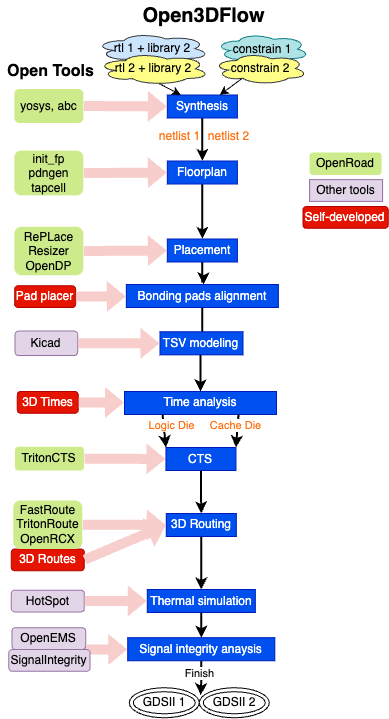

Within green boxes are existing open-source tools/algorithms such as Yosys and RePlace, which have been integrated into OpenRoad. The purple boxes represent the new open-source EDA tools we add to our design process. While the red boxes highlight our self-developed modules: 
1. Pad placer generates a bonding layer, placing bonding pads and ensuring alignment between two tiles; 
2. 3D Times extracts the delay introduced by TSVs, incorporating it into the subsequent CTS process. 
3. Route helper manages routing connections between metal layers and bonding pads, while also extracting parasitic parameters associated with the chiplets. 

### 5.2 Simulation Results
We have tegrated all of them into our docker environment. For simulation:

- Firstly, you should install docker (https://docs.docker.com/engine/install) and pull our image: (ps. Colab may not support docker)

In [ ]:
# pull our image:
!docker pull b224hisl/open3dflow:latest #For it's about 15GB, it may take a while
!docker tag b224hisl/open3dflow test # rename your environment

latest: Pulling from b224hisl/open3dflow
Digest: sha256:9c3d749d616d89b7e1b938f5bdd9cd7446bfb51aecb905d1962a49de9aef2942
Status: Image is up to date for b224hisl/open3dflow:latest
docker.io/b224hisl/open3dflow:latest


Note that "vncserver" (https://www.digitalocean.com/community/tutorial-collections/how-to-install-and-configure-vnc) should be installed to save the image from OpenRoad. if you don't care about the images, just want to get the gds, you can skip this step.

In [50]:
!vncserver


New 'server1:1 (yzhu)' desktop is server1:1

Starting applications specified in /work/stu/yzhu/.vnc/xstartup
Log file is /work/stu/yzhu/.vnc/server1:1.log



- Secondly, write the script executed in the docker environment: 

In [50]:
!rm -rf Results
!mkdir Results

In [51]:
%%writefile Results/script.sh
#!/bin/bash
source /home/dependency/oss-cad-suite/environment
export QT_QPA_PLATFORM=offscreen
cd /Flow

# sub die
export DESIGN_CONFIG=./designs/130_180/riscv32i_3d/config.mk
make clean_all
make
cp ./results/130_180/riscv32i_3d/80MHz/6_final.gds /Work_dir/core.gds
cp ./reports/130_180/riscv32i_3d/80MHz/final_routing.webp.png /Work_dir/core.png

# top die
export DESIGN_CONFIG=./designs/130_180/fakeram4/config.mk
make clean_all
make
cp ./results/gf180/fakeram4/80MHz/6_final.gds /Work_dir/sram.gds
cp ./reports/gf180/fakeram4/80MHz/final_routing.webp.png /Work_dir/sram.png
touch /Work_dir/script_completed.txt

Writing Results/script.sh


- Next, harden the design: (ps. Since Jupyter Notebook is not convenient for displaying GUI, here we will only run a simple chip back-end script, and the specific analysis of some steps will be presented in the following chapters.)

In [52]:
!docker run -d --rm --name Open3DFlow_s -e DISPALY=${DISPLAY} -v /tmp/.X11-unix:/tmp/.X11-unix -v ${HOME}/.Xauthority:/.Xauthority:ro -v $(pwd)/Open3DFlow:/Flow -v $(pwd)/Results:/Work_dir --network=host --privileged=true --security-opt seccomp=unconfined test:latest /bin/bash -c "bash /Work_dir/script.sh && echo succeed!"

4e4ea0b4f5d90f5747a8f5050e69c3db79f725fc5adf4817109e1c71a7ade9b6



The docker script runs for a relatively long time in the background (about 30 minutes), and you could use the following codes to monitor whether the harden process has ended:

In [53]:
import os  
import time  
  
# Define the waiting interval and the maximum waiting time.
wait_interval = 20   
max_wait_time = 3600  
  
container_name = "Open3DFlow_s"  
marker_file = "./Results/script_completed.txt" 
marker_file_exists = False  
start_time = time.time()  
  
# Poll to check if the marker file exists. 
while not marker_file_exists and (time.time() - start_time) < max_wait_time:  
    if os.path.exists(marker_file):  
        marker_file_exists = True  
    else:  
        print(f"Waiting for the script to complete. Checking again after {wait_interval} seconds...")  
        time.sleep(wait_interval)  
  
if marker_file_exists:  
    print("Script execution in the container has completed!")  
else:  
    print(f"Script did not complete within {max_wait_time} seconds.") 

Waiting for the script to complete. Checking again after 20 seconds...


Waiting for the script to complete. Checking again after 20 seconds...
Waiting for the script to complete. Checking again after 20 seconds...
Waiting for the script to complete. Checking again after 20 seconds...
Waiting for the script to complete. Checking again after 20 seconds...
Waiting for the script to complete. Checking again after 20 seconds...
Waiting for the script to complete. Checking again after 20 seconds...
Waiting for the script to complete. Checking again after 20 seconds...
Waiting for the script to complete. Checking again after 20 seconds...
Waiting for the script to complete. Checking again after 20 seconds...
Waiting for the script to complete. Checking again after 20 seconds...
Waiting for the script to complete. Checking again after 20 seconds...
Waiting for the script to complete. Checking again after 20 seconds...
Waiting for the script to complete. Checking again after 20 seconds...
Waiting for the script to complete. Checking again after 20 seconds...
Waitin

In [ ]:
# insall the dependencies
!pip install gdstk matplotlib

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


This is the die image of the sub die (Core Die):

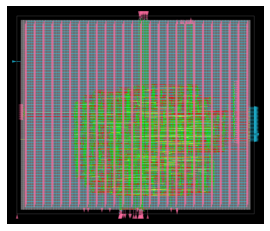

In [54]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
core = mpimg.imread('Results/core.png')
#core.shape [:3]
plt.imshow(core)
plt.axis('off')
plt.show()

This is the die image of the top die (Sram Die):

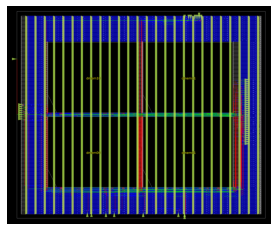

In [2]:
sram = mpimg.imread('Results/sram.png')
#core.shape [:3]
plt.imshow(sram)
plt.axis('off')
plt.show()

### 5.3. Discussion
We have zoomed in on the detailed images to further demonstrate that the two dies can be coupled. The following image shows the core die and cache die in the sky130A and GF180 process respectively.

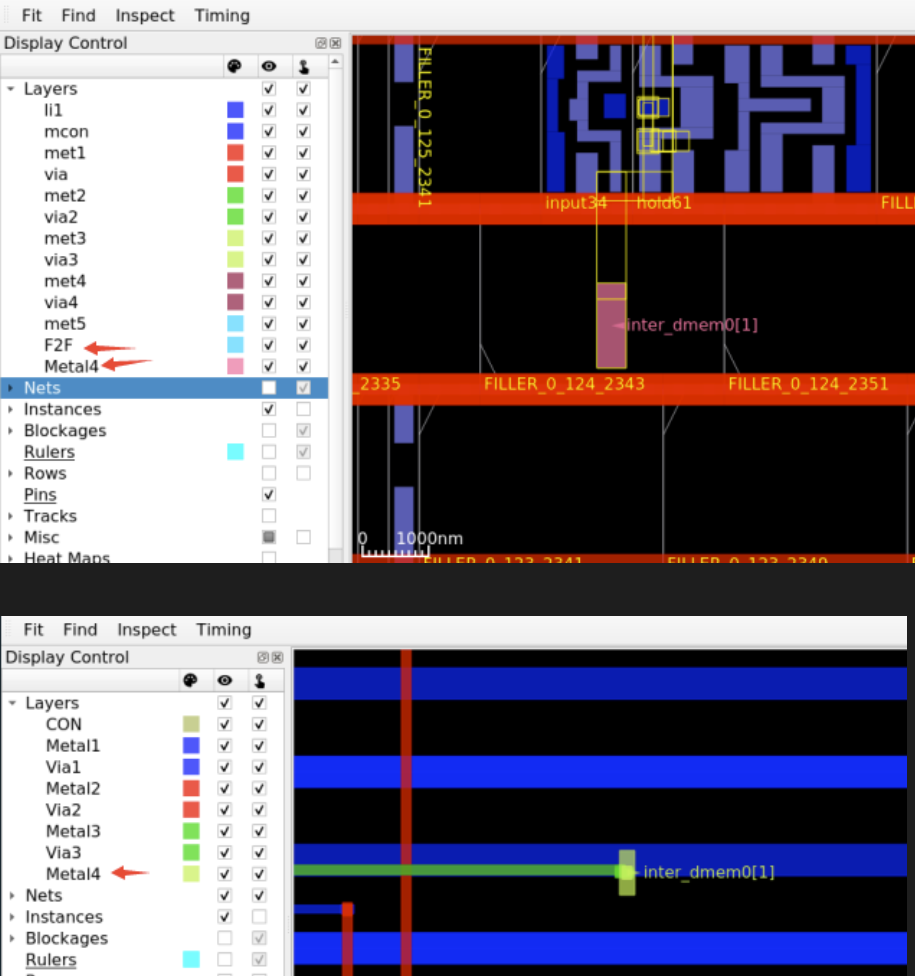

Our objective is to mimic the AMD 3D Vcache model. Both dies have identical footprints, with corresponding signal bonding pads positioned internally within the die.

To simulate their respective real-world conditions as accurately as possible within the entire 3D system, we have conducted separate simulations for the two dies. As you can see, we have modified the BEOL of the core die, with Metal4's parameters derived from the top layer of GF180, while the RC parameters for the ‘F2F’ via layer are calculated by the average of two PDKs' cut layers. To avoid potential debugging complexities related to the interaction of two different PDKs, Metal4 is not used for routing for the cache die. Instead, it serves as a bonding layer, where the routing endpoints of both chips converge.

## 6.    3D Timing Analysis with TSV Modeling
### 6.1  3D Parastic Extraction
We extracted parasitic parameters based on chips' geometric dimensions and material properties of the TSV structure. In this model, copper is chosen as the filling metal, and the relevant structure and parameters are depicted in this figure:

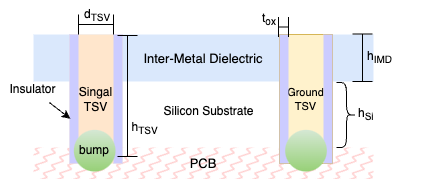

The parasitic resistance $R_{TSV}$ consists of two components: the direct-current resistance $R_{dc,TSV}$ and the alternating-current resistance $R_{ac,TSV}$. The former one follows Ohm's law, while the other is determined by skin depth and proximity effect:
$$R_{TSV}=\sqrt{R_{dc,TSV}^2 + R_{ac,TSV}^2}$$

The external inductance $L_{ex,TSV}$ arises from the electromagnetic fields present in the dielectric region, making it dependent solely on the geometry of the interconnect and the dielectric material. The internal inductance $L_{ex,TSV}$ is related to the distribution of current within the conductor. The total inductance can be calculated by relevant literatures, where $\delta$ represents the correction term accounting for skin effect and proximity effect:
$$L_{TSV}=\frac{h_{TSV}}{2} + \delta$$
Finally, we calculate the insulator capacitance $C_{insulator}$ by the coaxial capacitance formula  $f(h_{insulator}, d_{TSV}, t_{ox})$

### 6.2 Timing analysis of TSV
We have developed a symmetric H-type equivalent circuit model, as depicted in this figure, which incorporates both signal TSVs and ground TSVs:

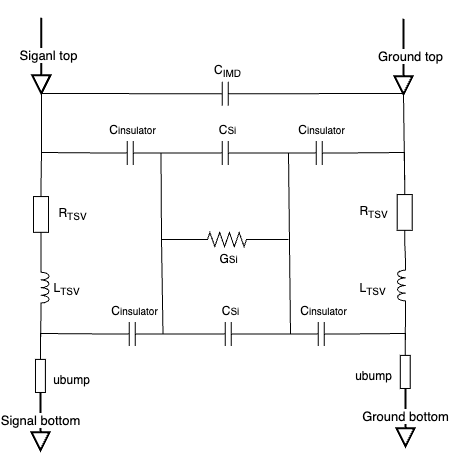

Due to the conductivity of the substrate material, $C_{si}$ and $G_{si}$ represent the parasitic capacitance and conductance, respectively, arising from electric field coupling. Additionally, $C_{IMD}$ is the capacitance of the metal interconnect layer, and $C_{RDL}$ denotes the parasitic capacitance of RDL interconnections. In this model, we solely consider the impedance contributed by the bumps.

### 6.3  SPICE Simulation in KiCAD

To investigate the impact of tsv on timing and RLC characteristics, we perform Spice simulations utilizing Kicad.
    (ps: Kicad has been integrated into our environment but we cannot open its gui in this notebook, so we just put the code and simulation results here):

In [26]:
%%writefile tsv.spice
## take frequency of 80Mhz for example
.title KiCad schematic
.save all
.probe alli
.probe p(C_insulator3)
.probe p(C_insulator4)
.probe p(R_TSV3)
.probe p(L_TSV2)
.probe p(R_TSV4)
.probe p(V2)
.probe p(C_insulator2)
.probe p(L_TSV1)
.probe p(R_TSV1)
.probe p(C_insulator1)
.probe p(V3)
.probe p(R_TSV2)
.probe p(C_IMD1)
.probe p(C_Si1)
.probe p(C_RDL1)
.probe p(R_Si1)
.tran 31.25p 12.5n 0
C_insulator3 unconnected-_C_insulator3-Pad1_ Net-_C_IMD1-Pad2_ 164.343f
C_insulator4 Net-_C_RDL1-Pad2_ Net-_C_insulator4-Pad2_ 164.343f
R_TSV3 Net-_C_IMD1-Pad2_ unconnected-_R_TSV3-Pad2_ 0.00347282
L_TSV2 Net-_C_insulator4-Pad2_ Net-_L_TSV2-Pad2_ 6.19242p
R_TSV4 unconnected-_R_TSV4-Pad1_ GND 0.03
V2 Net-_C_IMD1-Pad2_ GND PULSE( 0 1.8 0n 0n 0n 6.25n 12.5n )
C_insulator2 Net-_C_insulator2-Pad1_ Net-_C_RDL1-Pad1_ 164.343f
L_TSV1 Net-_C_insulator2-Pad1_ Net-_L_TSV1-Pad2_ 6.19242p
R_TSV1 Net-_C_IMD1-Pad1_ Net-_L_TSV1-Pad2_ 0.00347282
C_insulator1 Net-_C_IMD1-Pad1_ Net-_C_RDL1-Pad1_ 164.343f
V3 unconnected-_V3-Pad1_ GND PULSE( 0 1.8 0n 0n 0n 6.25n 12.5n )
R_TSV2 unconnected-_R_TSV2-Pad1_ GND 0.03
C_IMD1 unconnected-_C_IMD1-Pad1_ Net-_C_IMD1-Pad2_ 4.11862e-16
C_Si1 Net-_C_RDL1-Pad1_ Net-_C_RDL1-Pad2_ 1.27899f
C_RDL1 Net-_C_RDL1-Pad1_ Net-_C_RDL1-Pad2_ 2.79443e-16
R_Si1 Net-_C_RDL1-Pad1_ Net-_C_RDL1-Pad2_ 27188
.end

Writing tsv.spice


Signal delay detection is determined by a threshold set at 90\% of its peak value. The figures and table exhibit the delay profiles for signal frequencies spanning from 25MHz to 2GHz, where the normalized delay signifies the proportion of delay to the time period:

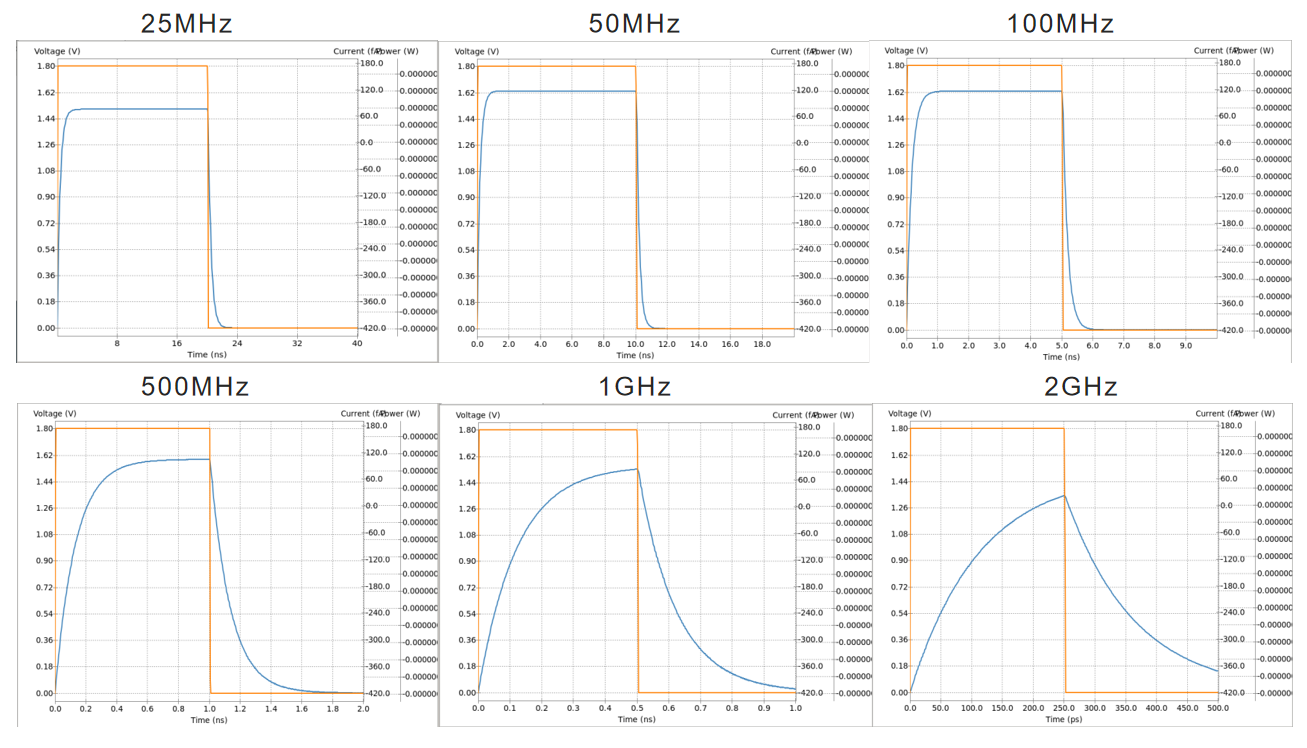

| Frequency （Hz） | Time period (ns) | Delay(ns) | Normalized Delay |
| ---------------- | ---------------- | --------- | ---------------- |
| 25M              | 40               | 0.60      | 0.015            |
| 50M              | 20               | 0.45      | 0.023            |
| 80M <-our design | 12.5             | 0.41      | 0.03             |
| 100M             | 10               | 0.40      | 0.04             |
| 500M             | 2                | 0.30      | 0.15             |
| 1G               | 1                | 0.26      | 0.26             |
| 2G               | 0.5              | 0.18      | 0.36             |

Notably, as the frequency increases, the delay introduced by TSV becomes increasingly significant, particularly exceeding one-third of the entire signal duration for frequencies above Ghz.

We have integrated the corresponding delays into our design flow by 3D times, ensuring that subsequent steps such as CTS and routing take into account the influencing factors of TSVs.

## 7. 3D Thermal Simulation and Signal Integrity Analysis
### 7.1 Thermal Modeling and Simulation
When stacking chips, a major issue arises as to how to dissipate the heat generated in the middle of the two chips. Hence, during the development of chip packaging, engineers should employ CAE calculation and multi-physical field coupling simulation to analyze heat flow within the packaging. This allows them to manage heat transfer paths, reduce chip die temperature, and enhance thermal reliability.

In this work, we divide the core die and cache die into 30 module grids and 5 unit grids respectively, as shown in the following figures:

Core Die:

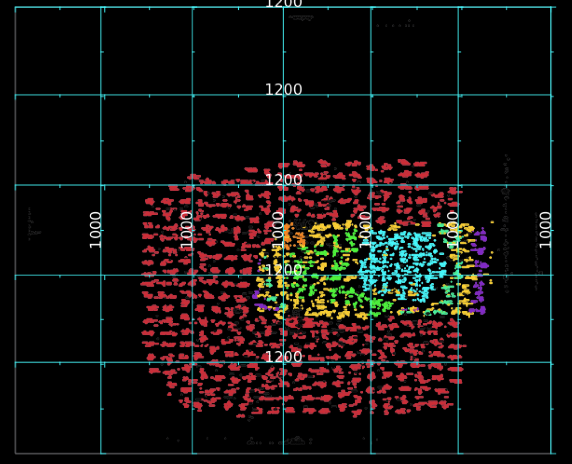

Cache Die:

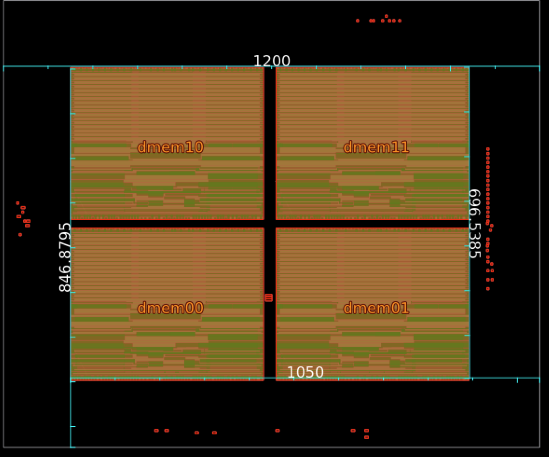

We proceed by computing the number of active cells in each grid and allocating the overall power consumption accordingly. For thermal simulation, it is imperative to extract critical parameters related to the 3D stack structure, encompassing material properties, electrical characteristics, dimensions. These parameters include chip thickness, thermal conductivity, volumetric heat capacity, package model, floorplan/stacking information, and etc. Subsequently, we establish a model of the external environment, configuring factors such as heat sink, heat spreader specifications, ambient temperature settings, and so on.

HotSport, an open-source pre-RTL thermal simulator, serves as the primary EDA tool for executing this step. Within our simulation, we have established five material layers to facilitate the transfer of thermal effects: heat sink, heat spreader, cache die, core die, and package layer. The geometric arrangement of these layers is depicted in the accompanying figure:

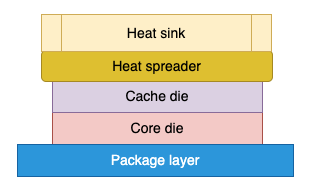

We use HotSpot to do that simulation, a demonstration flow is shown here:

In [55]:
!mkdir Thermal_sim

In [56]:
!cp -r ./Open3DFlow/thermal ./Thermal_sim

In [57]:
%%writefile Results/script2.sh
#!/bin/bash
cd /Thermal_sim/
git clone https://github.com/uvahotspot/HotSpot.git
cd HotSpot && make SUPERLU=1
mv ../thermal/ ./examples/
cd examples/thermal
sh run.sh
cp outputs/*.png /Work_dir/

Writing Results/script2.sh


In [58]:
!docker run --rm --name thermal_sim -e DISPALY=$DISPLAY -v /tmp/.X11-unix:/tmp/.X11-unix -v ${HOME}/.Xauthority:/.Xauthority:ro -v $(pwd)/Thermal_sim:/Thermal_sim -v $(pwd)/Results:/Work_dir --network=host --privileged=true --security-opt seccomp=unconfined test:latest /bin/bash -c "bash /Work_dir/script2.sh && echo succeed"

Cloning into 'HotSpot'...
gcc -O3  -I/usr/include/superlu/  -DVERBOSE=1 -DMATHACCEL=0 -DSUPERLU=1 -c hotspot.c
hotspot.c: In function 'read_names':
hotspot.c:190:7: warning: ignoring return value of 'fgets', declared with attribute warn_unused_result [-Wunused-result]
  190 |       fgets(line, LINE_SIZE, fp);
      |       ^~~~~~~~~~~~~~~~~~~~~~~~~~
hotspot.c: In function 'read_vals':
hotspot.c:224:7: warning: ignoring return value of 'fgets', declared with attribute warn_unused_result [-Wunused-result]
  224 |       fgets(line, LINE_SIZE, fp);
      |       ^~~~~~~~~~~~~~~~~~~~~~~~~~
gcc -MM -O3  -I/usr/include/superlu/  -DVERBOSE=1 -DMATHACCEL=0 -DSUPERLU=1 hotspot.c > hotspot.d
gcc -O3  -I/usr/include/superlu/  -DVERBOSE=1 -DMATHACCEL=0 -DSUPERLU=1 -c microchannel.c
microchannel.c: In function 'microchannel_build_network':
microchannel.c:296:3: warning: ignoring return value of 'fgets', declared with attribute warn_unused_result [-Wunused-result]
  296 |   fgets(line, MAX_LINE_SIZE,

The following figures show the thermal simulation results of cache die and logic die respectively：

- Core Die:

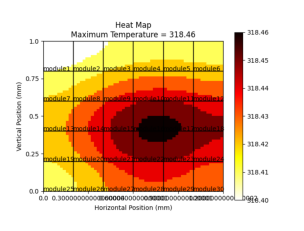

In [59]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
core = mpimg.imread('Results/core_thermal.png')

plt.imshow(core)
plt.axis('off')
plt.show()

- Cache Die

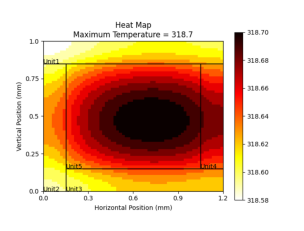

In [60]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
core = mpimg.imread('Results/cache_thermal.png')

plt.imshow(core)
plt.axis('off')
plt.show()

### 7.2 Signal Integrity Analysis
As data transmission rates soar into the tens of gigabits per second, digital signals exhibit characteristics reminiscent of microwaves, becoming vulnerable to reflections, damping, and crosstalk. An overly ambitious design can easily be compromised by impedance mismatches or interference among copper traces. As a consequence, in the design process of 3D ICs, SI analysis stands as a crucial element.

The key for SI is to extract the s-parameters of the circuits or the chip. We consider studying the transmission performance between the V-cache die and the core die, as shown in the figure:

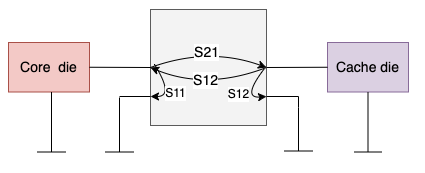

Similarly, when delving into the intricate details of the chip, 3D components such as TSVs also require corresponding modeling. We have investigated a range of existing open-source EDA software and initially considered utilizing OpenEMS, an open electromagnetic field solver that employs the Finite Difference Time Domain (FDTD) method, for this purpose. However, the primary challenge lies in the fact that there are currently no open-source tools that can convert GDSII files into the three-dimensional mesh required by this software. Therefore, we are exploring a compromise approach. Firstly, through circuit modeling and RLC parameter extraction, we abstract the respective metal stacks into electrical circuits. Subsequently, we leaverage an open Python library called SignalIntegrity for S-parameter extraction. Finally, by combining information such as the dimensions, materials, and external environment of the 3D chiplet, we aim to obtain eye diagrams, Smith charts, and other relevant metrics.

As of the submission of this paper, our SI analysis is still ongoing. We are committed to developing a comprehensive 3D IC design flow, which encompasses every aspect of the design process, ensuring a seamless transition from concept to implementation.

## 8. Conclusion

In conclusion, we have designed an open-source 3D RISC-V processor for this competition. To realize this architecture, we have developed Open3Dflow, an innovative open source 3D chip EDA Design Platform equipped with TSV and thermal modeling. This platform leverages existing openEDA tools, incorporating appropriate abstractions and modeling techniques tailored for 3D design. Additionally, we have adopted the openPDKs to facilitate future openMPW tape-outs.

Our design mimics AMD's 3D V-cache structure, featuring a cache die stacked onto the logic die. The back-end process incorporates distinct technology processes, sky130A and GF180, for the two tiles respectively. To further enhance its compatibility with advanced packaging, we have incorporated bonding pads for hybrid bonding, along with TSVs for electrical transmission. Furthermore, we have thoroughly validated our design through thermal modeling and SI assessments, ensuring a comprehensive evaluation of its performance.

Looking ahead, our 3D RISC-V CPU design, powered by Open3Dflow, holds immense potential in driving innovation within the semiconductor industry. By enabling the creation of more efficient, reliable, and cost-effective devices, it marks a significant milestone towards the realization of a fully open-source process for designing 3D chips. However, our current design remains a preliminary blueprint, and we eagerly anticipate the development of more realistic and feasible 3D chiplets within a fully open-source toolchain. There is ample room for improvement, such as optimizing the thermal performance of the chip, enhancing multi-objective optimization for 3D interconnects, and gracefully resolving DRC issues arising from chip stacking through the integration of two PDKs. We are committed to continuous progress, employing more comprehensive modeling techniques, developing new tools, and realizing increasingly complex designs to refine our design platform.

## Quick Start<a id="Quick Start"></a>
This chapter is a collection of all the codes. If you only want to replicate our simulation flow, a summary is provided here. When running, please do not execute the previous codes.

#### Prerequisite
- vnc  (https://www.digitalocean.com/community/tutorial-collections/how-to-install-and-configure-vnc)
- docker （https://docs.docker.com/engine/install; ps. Colab doesn't support docker, you need to use your jupyter notebook to run these codes) 

#### 1. Pull the environment

In [1]:
# pull our image:
!docker pull b224hisl/open3dflow:latest #For it's about 15GB, it may take a while
!docker tag b224hisl/open3dflow test # rename your environment

latest: Pulling from b224hisl/open3dflow
Digest: sha256:9c3d749d616d89b7e1b938f5bdd9cd7446bfb51aecb905d1962a49de9aef2942
Status: Image is up to date for b224hisl/open3dflow:latest
docker.io/b224hisl/open3dflow:latest


#### 2. Clone our source code
   The codes include: riscv32i RTL, gf180 sram marco file, back-end scripts, Open3DFlow platform, thermal config etc.

In [21]:
!git clone https://github.com/b224hisl/Open3DFlow.git
!cd Open3DFlow
!git pull
!cd ..

Cloning into 'Open3DFlow'...
remote: Enumerating objects: 824, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 824 (delta 7), reused 27 (delta 5), pack-reused 790
Receiving objects: 100% (824/824), 113.77 MiB | 4.14 MiB/s, done.
Resolving deltas: 100% (197/197), done.
Updating files: 100% (787/787), done.
Already up to date.


#### 3. TSV Modeling
spice simulation in KiCAD: (This has been integrated into our environment but we cannot open its gui in this notebook, so we just put the codes here and simulation results are in previous section)

In [3]:
%%writefile tsv.spice
## take frequency of 80Mhz for example
.title KiCad schematic
.save all
.probe alli
.probe p(C_insulator3)
.probe p(C_insulator4)
.probe p(R_TSV3)
.probe p(L_TSV2)
.probe p(R_TSV4)
.probe p(V2)
.probe p(C_insulator2)
.probe p(L_TSV1)
.probe p(R_TSV1)
.probe p(C_insulator1)
.probe p(V3)
.probe p(R_TSV2)
.probe p(C_IMD1)
.probe p(C_Si1)
.probe p(C_RDL1)
.probe p(R_Si1)
.tran 31.25p 12.5n 0
C_insulator3 unconnected-_C_insulator3-Pad1_ Net-_C_IMD1-Pad2_ 164.343f
C_insulator4 Net-_C_RDL1-Pad2_ Net-_C_insulator4-Pad2_ 164.343f
R_TSV3 Net-_C_IMD1-Pad2_ unconnected-_R_TSV3-Pad2_ 0.00347282
L_TSV2 Net-_C_insulator4-Pad2_ Net-_L_TSV2-Pad2_ 6.19242p
R_TSV4 unconnected-_R_TSV4-Pad1_ GND 0.03
V2 Net-_C_IMD1-Pad2_ GND PULSE( 0 1.8 0n 0n 0n 6.25n 12.5n )
C_insulator2 Net-_C_insulator2-Pad1_ Net-_C_RDL1-Pad1_ 164.343f
L_TSV1 Net-_C_insulator2-Pad1_ Net-_L_TSV1-Pad2_ 6.19242p
R_TSV1 Net-_C_IMD1-Pad1_ Net-_L_TSV1-Pad2_ 0.00347282
C_insulator1 Net-_C_IMD1-Pad1_ Net-_C_RDL1-Pad1_ 164.343f
V3 unconnected-_V3-Pad1_ GND PULSE( 0 1.8 0n 0n 0n 6.25n 12.5n )
R_TSV2 unconnected-_R_TSV2-Pad1_ GND 0.03
C_IMD1 unconnected-_C_IMD1-Pad1_ Net-_C_IMD1-Pad2_ 4.11862e-16
C_Si1 Net-_C_RDL1-Pad1_ Net-_C_RDL1-Pad2_ 1.27899f
C_RDL1 Net-_C_RDL1-Pad1_ Net-_C_RDL1-Pad2_ 2.79443e-16
R_Si1 Net-_C_RDL1-Pad1_ Net-_C_RDL1-Pad2_ 27188
.end

Writing tsv.spice


#### 4. Chip hardeninng

i) write the configuration files of the core die and cache die:

In [4]:
%%writefile core_die.mk
export DESIGN_NICKNAME = riscv32i_3d
export DESIGN_NAME = core_without_dmem
# top = dmem + core_without_dmem
export PLATFORM    = 130_180 #sky130 & GF180
export PLACE_DENSITY          = 0.5

export SYNTH_HIERARCHICAL = 1
export RTLMP_FLOW = True
export MAX_UNGROUP_SIZE ?= 1000

export VERILOG_FILES = $(sort $(wildcard ./designs/src/riscv32i_3d/*.v))
export SDC_FILE      = ./designs/130_180/$(DESIGN_NICKNAME)/constraint.sdc

export DIE_AREA = 0 0 1200 1000
export CORE_AREA = 20 20 1180 980

export PLACE_DENSITY_LB_ADDON = 0.12
export MACRO_PLACE_CHANNEL = 6 6
export TNS_END_PERCENT   = 100
export MIN_ROUTING_LAYER = met1
export BONDING_LAYER = Metal4
export MAX_ROUTING_LAYER = $(BONDING_LAYER)

export IO_CONSTRAINTS = ./designs/$(PLATFORM)/$(DESIGN_NICKNAME)/io.tcl
export IS_CHIP = 1
export MOTHER_PIN_GEN = ./designs/$(PLATFORM)/$(DESIGN_NICKNAME)/pad_gen.tcl
export TSV_DELAY = $[from_3D_times]
export PDN_TCL = ./designs/$(PLATFORM)/$(DESIGN_NICKNAME)/pdn.tcl

Writing core_die.mk


In [5]:
%%writefile sram_die.mk
export DESIGN_NICKNAME = fakeram4
export DESIGN_NAME = dmem
export PLATFORM    = gf180
export MOTHER_PLATFORM = 130_180 #sky130 & GF180
export PLACE_DENSITY          = 0.7

export VERILOG_FILES = ./designs/src/riscv32i_3d/dmem_real
export SDC_FILE      = ./designs/$(MOTHER_PLATFORM)/$(DESIGN_NICKNAME)/constraint.sdc

export DIE_AREA = 0 0 1200 1000
export CORE_AREA = 20 20 1180 980

BLOCKS = gf180mcu_fd_ip_sram__sram256x8m8wm1

export MACRO_PLACEMENT_TCL = ./designs/$(MOTHER_PLATFORM)/$(DESIGN_NICKNAME)/macro.tcl

export MACRO_PLACE_HALO    = 1 1
export MACRO_PLACE_CHANNEL = 0 0

export PDN_TCL = ./designs/$(MOTHER_PLATFORM)/$(DESIGN_NICKNAME)/pdn.tcl


export GPL_ROUTABILITY_DRIVEN = 1

export IS_CHIP = 1

export MIN_ROUTING_LAYER = Metal1
export MAX_ROUTING_LAYER = Metal3

export MOTHER = riscv32i_3d # mother die is logic part
export MOTHER_PDK = 130_180

export IO_CONSTRAINTS = ./designs/$(MOTHER_PLATFORM)/$(DESIGN_NICKNAME)/pad_placer.tcl

Writing sram_die.mk


ii) Write the script executed in the docker environment:

In [22]:
!rm -rf Results
!mkdir Results

In [23]:
%%writefile Results/script.sh
#!/bin/bash
source /home/dependency/oss-cad-suite/environment
export QT_QPA_PLATFORM=offscreen
cd /Flow

# sub die
export DESIGN_CONFIG=./designs/130_180/riscv32i_3d/config.mk
make clean_all
make
cp ./results/130_180/riscv32i_3d/80MHz/6_final.gds /Work_dir/core.gds
cp ./reports/130_180/riscv32i_3d/80MHz/final_routing.webp.png /Work_dir/core.png

# top die
export DESIGN_CONFIG=./designs/130_180/fakeram4/config.mk
make clean_all
make
cp ./results/gf180/fakeram4/80MHz/6_final.gds /Work_dir/sram.gds
cp ./reports/gf180/fakeram4/80MHz/final_routing.webp.png /Work_dir/sram.png
touch /Work_dir/script_completed.txt

Writing Results/script.sh


iii) Harden the Design

In [24]:
!vncserver


New 'server1:1 (yzhu)' desktop is server1:1

Starting applications specified in /work/stu/yzhu/.vnc/xstartup
Log file is /work/stu/yzhu/.vnc/server1:1.log



In [ ]:

!docker run -d --rm --name Open3DFlow_s -e DISPALY=${DISPLAY} -v /tmp/.X11-unix:/tmp/.X11-unix -v ${HOME}/.Xauthority:/.Xauthority:ro -v $(pwd)/Open3DFlow:/Flow -v $(pwd)/Results:/Work_dir --network=host --privileged=true --security-opt seccomp=unconfined test:latest /bin/bash -c "bash /Work_dir/script.sh && echo succeed!"

#### 5. Thermal Simulation

In [38]:
!mkdir Thermal_sim

In [39]:
!cp -r ./Open3DFlow/thermal ./Thermal_sim

In [40]:
%%writefile Results/script2.sh
#!/bin/bash
cd /Thermal_sim/
git clone https://github.com/uvahotspot/HotSpot.git
cd HotSpot && make SUPERLU=1
mv ../thermal/ ./examples/
cd examples/thermal
sh run.sh
cp outputs/*.png /Work_dir/

Overwriting Results/script2.sh


In [ ]:
!docker run --rm --name thermal_sim -e DISPALY=$DISPLAY -v /tmp/.X11-unix:/tmp/.X11-unix -v ${HOME}/.Xauthority:/.Xauthority:ro -v $(pwd)/Thermal_sim:/Thermal_sim -v $(pwd)/Results:/Work_dir --network=host --privileged=true --security-opt seccomp=unconfined test:latest /bin/bash -c "bash /Work_dir/script2.sh && echo succeed"

#### 6. Visualization

Because the GDS svg file is too large to open in this notebook, we just display the screenshots here. The svg files are also generated.

In [33]:
# insall the dependencies
!pip install gdstk matplotlib

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


Die image of the sub die (Core Die):

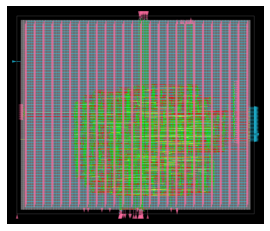

In [43]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
core = mpimg.imread('Results/core.png')
#core.shape [:3]
plt.imshow(core)
plt.axis('off')
plt.show()

Die image of the top die (Sram Die):

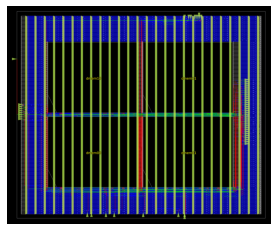

In [44]:
sram = mpimg.imread('Results/sram.png')
#core.shape [:3]
plt.imshow(sram)
plt.axis('off')
plt.show()

Temperature distribution map of the core die:

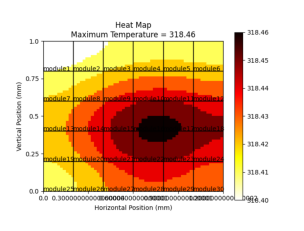

In [45]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
core = mpimg.imread('Results/core_thermal.png')

plt.imshow(core)
plt.axis('off')
plt.show()

Temperature distribution map of the cache die:

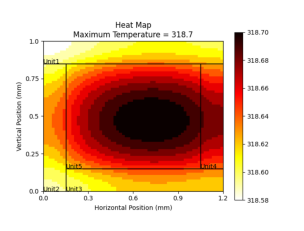

In [46]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
core = mpimg.imread('Results/cache_thermal.png')

plt.imshow(core)
plt.axis('off')
plt.show()